In [3]:
import os
from time import time

class gene:
    def __init__(self, name, primers):
        self.name = name
        self.primers = primers
        return
    
class primer_pair:
    def __init__(self, A, B, name, count):
        self.id = f"{name}-{count}"
        self.gene = name
        self.dimer = 999
        self.fseq = A.split("+")[0]
        self.rseq = A.split("+")[3]
        self.fstart = A.split("+")[2]
        self.penalty = B.split("-")[0]
        self.ftm = B.split("-")[1]
        self.rtm = B.split("-")[2]
        self.ampliconlen = B.split("-")[3]
        self.path = []
        self.neighbours = []
        return  



In [5]:
#import the primer set generated from step 1
import pickle

os.chdir("/home/flan3@ad.wisc.edu/MplexPrimerPicker/projects/zymofecal")

with open("Primers.pickle", "rb") as infile:
    genelist = pickle.load(infile)

glist = []
count = 0
for g in genelist:
    plist = []
    for p in genelist[g]:
        plist.append(p)
        #print(p.id)
        count+= 1
    glist.append(gene("|".join(p.gene.split("|")[-2:]), plist))
genelist = glist
print(count, "total primers")

#move the 16S and adaptor sequences to the top slot
genelist.insert(0, genelist.pop(-1))
genelist.insert(0, genelist.pop(-1))

for g in genelist:
    print(g.name)

1002 total primers
P5/P7
16S
rep_cluster_1320
rep_cluster_663
Inc18
rep_cluster_1351
rep_cluster_1868
rep_cluster_1702
rep_cluster_414
rep_cluster_1817
Col156
rep_cluster_1778


In [6]:
#load up the calculated primer dimer free energies from step 2
import pickle
with open("adjdict-noadaptors.pickle", "rb") as infile:
    adjdict = pickle.load(infile)

In [44]:
adjdict

{frozenset({'rep_cluster_1320-0', 'rep_cluster_663-0'}): -3226.32,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-1'}): -3226.32,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-2'}): -5719.17,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-3'}): -7062.16,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-4'}): -4890.03,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-5'}): -5027.43,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-6'}): -4368.95,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-7'}): -4890.03,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-8'}): -5027.43,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-9'}): -4368.95,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-10'}): -4368.95,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-11'}): -5719.17,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-12'}): -3226.32,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-13'}): -3226.32,
 frozenset({'rep_cluster_1320-0', 'rep_cluster_663-14'}): 

In [76]:
#simulated annealing algorithm to find more different sets
import random
import numpy as np
from time import process_time
import sys

def get_scores(pmr1, pmr2, adaptorweight): #this this function uses the dif adj dicitonary calcualted from ntthal
    return adjdict[frozenset((pmr1.id,pmr2.id))]

def sim_anneal(T = 10, length = 1, adaptorweight = 1, beta = 0.99):
    #THIS ALGORITHM ASSUMES P5/P7 and 16S are the first 2 in the list of genes!
    #FOR OTHER CASES WHERE THIS DOES NOT APPLY, REMOVE THE FOLLOWING IF STATEMENT
    if genelist[0].name != "P5/P7" or genelist[1].name != "16S":
        print("Gene order not as expected! Exiting")
        return "error"
    #########################################################
    min_history = [] #keep track of scores to see how the annealing is doing
    avg_history = [] #keep track of scores to see how the annealing is doing
    Temp_history = [] #keep track of temperature history for adjusting
    tstart = time() 
    tend = tstart + 60*length #length is input as minutes
    cycles = 0 #keep track of how many cycles we've done
    bestscore = -9999
    bestset = []

    #1. start with an initial random state
    pset = []
    for g in genelist: #making sure that the order of genes in the pset is same as order in "genes"
        pset.append(random.choice(g.primers))

    #calculate score for this set
    scores1 = np.zeros((len(pset),len(pset))) 
    for i in range(len(pset)):
        for j in range(i): #every comparison between different primersets
            scores1[i,j] = get_scores(pset[i], pset[j], adaptorweight)
            scores1[j,i] = scores1[i,j] #make it symmetrical for later row-summing reasons

    #start iterating through simulated annealing
    while time() < tend: #timed annealing process

        #2. propose a new random set where one gene is changed
        psetnew = pset

        scoresrow = np.sum(scores1, axis = 0) #sum the rows to get aggregate scores for each primer to help choose which one to change   
        
        #probabilistic picking of worst performing gene or any random gene
        if random.random() >= 0.2: #80% most of the time pick the worst perfomring primer
            c = np.argmin(scoresrow[2:])+2  #select the position with worst score to change 
            #start from 2 to avoid changing P5/P7 or 16S primer, which there is no choice to change anyways.
            #the +2 is to account for the index offset when we subset the scoresrow list to remove the first 2 entries
        else:
            c = random.choice(range(len(pset))) #20% of the time, just choose random position to change
            
        psetnew[c] = random.choice(genelist[c].primers) #get a new primer for that position

        #3. score new primer set
        scores2 = np.zeros((len(pset),len(pset))) 
        for i in range(len(pset)):
            for j in range(i+1, len(pset)):
                scores2[i,j] = get_scores(psetnew[i], psetnew[j], adaptorweight)
                scores2[j,i] = scores2[i,j]

        #4. compare both scores and decide to accept or not
        E1 = -1*np.mean(scores1)
        E2 = -1*np.mean(scores2)
        if E1 > E2: #update it if old score is worse than new score
            pset = psetnew
            scores1 = scores2 #also update the scores
        else:
            if np.exp(-(E2-E1)/T) > random.random():   #also probability of taking newpset even if it isn't better
                pset = psetnew
                scores1 = scores2 #also update the scores

        #also keep track of the best performing set in history #we'll make a combo of min + avg scores
        if np.mean(bestscore) + np.amin(bestscore)/2 < np.mean(scores2) + np.amin(scores2)/2: #bestset is worse than score2
            #update bestset 
            bestscore = scores2
            bestset = psetnew
        
        #5. Add to minscorelist to keep track of annealing history
        cycles += 1
        if cycles%10 == 0: #every 10 cycles
            min_history.append(np.amin(scores1))
            avg_history.append(np.mean(scores1))
            Temp_history.append(T)

        #we also need a cooling schedule, T decreases with each x iterations
        if cycles%100 == 0: #every 100 cycles
            T = T*beta

        
    #report the score at the end
    print(f"min score of the best primerset: {np.amin(bestscore)}")
    print(f"avg score of the best primerset: {np.mean(bestscore)}")

    print(f"settings used beta {beta} runtime {length}")

    return bestscore, bestset, min_history, avg_history, Temp_history #report bestset

In [77]:
#Test settins for simulated annealing to get satisfactory settings before  large parallel run
#tune the T and length settings until you get satisfactory results
scores, pset, minhistory, avghistory, temp = sim_anneal(length = 0.2, adaptorweight = 1, T = 600, beta = 0.997)

min score of the best primerset: -6100.4
avg score of the best primerset: -3898.526805555556
settings used beta 0.997 runtime 0.2


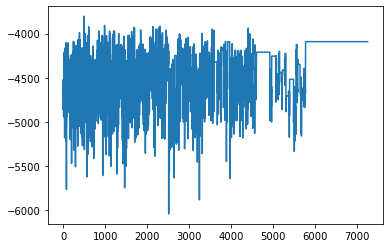

In [78]:
import matplotlib.pyplot as pyplot
%matplotlib inline
pyplot.plot(avghistory)

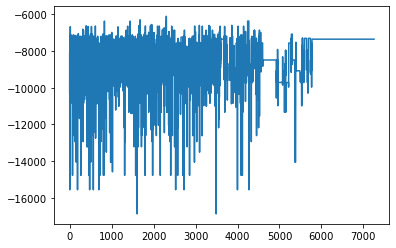

In [79]:
pyplot.plot(minhistory)

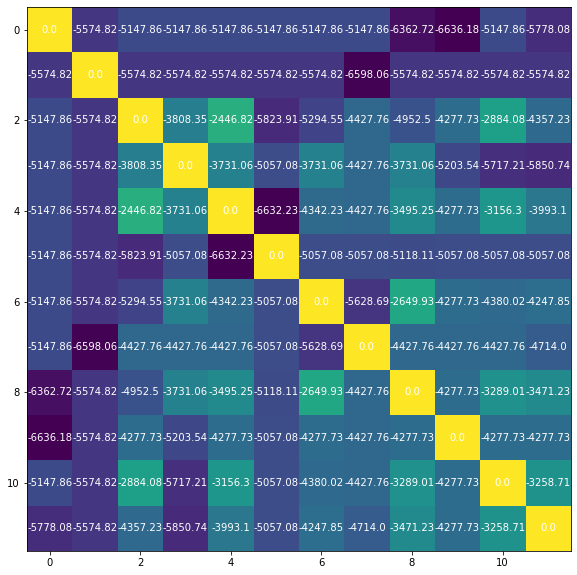

In [49]:
fig, ax = pyplot.subplots(figsize = (10,10))
ax.imshow(scores)
for i in range(len(scores)):
    for j in range(len(scores)):
        text = pyplot.text(j, i, scores[i, j],
                       ha="center", va="center", color="w")

In [80]:
#Run a parallelized version (200 iterations) to get the best results
import multiprocessing
from joblib import Parallel, delayed

results = Parallel(n_jobs=20)(delayed(sim_anneal)(length = 0.2, adaptorweight = 1, T = 600, beta = 0.997) for i in range(200)) #do the parallelized runs
#should take ~2 mins 

In [81]:
#Summarize the results

results.sort(key = lambda x: (np.min(x[0]) + np.mean(x[0])), reverse = True) #sort them based on combination of minimum and mean score

#take the top 10 and output as a csv file
with open("top10-sets.csv", "w") as outfile:
    for r in results[0:10]:
        print(f"Top 10 primersets {np.mean(r[0]), np.amin(r[0])}")
        for p in r[1]:
            outfile.write(f"{p.id}\t{p.fseq}\t{p.rseq}\t{p.ampliconlen}\t{np.mean(r[0])}\t{np.amin(r[0])}\n")



Top 10 primersets (-3607.785972222222, -5817.17)
Top 10 primersets (-3659.8481944444447, -5817.17)
Top 10 primersets (-3697.6526388888888, -5789.6)
Top 10 primersets (-3926.2913888888893, -5574.82)
Top 10 primersets (-3698.280972222222, -5817.17)
Top 10 primersets (-3708.9043055555553, -5817.17)
Top 10 primersets (-3964.988472222222, -5574.82)
Top 10 primersets (-3776.7237499999997, -5789.6)
Top 10 primersets (-3789.8984722222212, -5789.6)
Top 10 primersets (-3765.94, -5817.17)


In [81]:
#save the whole results file just in case
with open("top-10-sets.pickle", "wb") as infile:
    pickle.dump(results, infile)
    